- Welcome to Quantitative and High Frequency Trading Training Program


In [1]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
reload(helper)
reload(stats)
par_get_all_signal

<function helper.par_get_all_signal(signal_name, file_list, product, period, SAVE_PATH='e:/intern')>

In [2]:
import warnings
 
warnings.filterwarnings('ignore')

- number of cores, set this number according to your computer

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

- sample product, you can change to your specific product symbol

In [4]:
product_list = ["bu", "ru", "v", "pp", "l", "jd"]

In [5]:
import dask
from dask import compute, delayed

- sample period

In [6]:
period = 4096

In [7]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days

1066

- choose an example day

In [8]:
split_date = "201910"

train_sample = all_dates<split_date

test_sample = all_dates>split_date


In [9]:
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
SAVE_PATH = "e:/intern"

- at last we plot the selected pnl

- now we can see that the number of signals are not very big
- and the quality is not so good
- we can propose a systematic method to generate a large number of signals then
- we can choose good ones from them

- for example, we can first generate some signals about volatility without direction
- there are some ideas about it

- standard deviation
- range of price
- ratio of volume to turnover

- then we can generate some signals with direction
- actually all of our previous signals have direction
- but some of them are good and some of them are bad
- we can focus on some good and simple ones, such as

- normalized return
- rsi
- dbook

- let's try to generate range signals first

In [10]:
## calculate rolling standard deviation
from collections import OrderedDict
class foctor_std_period(factor_template):
    factor_name = "std.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return np.sqrt(fast_roll_var(data["wpr"], period))

In [11]:
## calcualte rolling variance
def fast_roll_var(x, period):
      x_ma = cum(x,period)/period ## roling first moment
      x2 = x*x
      x2_ma = cum(x2,period)/period ## rolling second moment
      var_x = x2_ma-x_ma*x_ma ## rolling variance
      return(var_x)

In [12]:
x20 = foctor_std_period()
for product in product_list:
    create_signal_path(x20, product, SAVE_PATH);

e:/intern/tmp pkl/bu/std.4096
e:/intern/tmp pkl/ru/std.4096
e:/intern/tmp pkl/v/std.4096
e:/intern/tmp pkl/pp/std.4096
e:/intern/tmp pkl/l/std.4096
e:/intern/tmp pkl/jd/std.4096


In [13]:
## rolling price range
from collections import OrderedDict
class foctor_range_period(factor_template):
    factor_name = "range.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return data["max."+str(period)]-data["min."+str(period)]

In [14]:
x21 = foctor_range_period()
for product in product_list:
    create_signal_path(x21, product, SAVE_PATH);

e:/intern/tmp pkl/bu/range.4096
e:/intern/tmp pkl/ru/range.4096
e:/intern/tmp pkl/v/range.4096
e:/intern/tmp pkl/pp/range.4096
e:/intern/tmp pkl/l/range.4096
e:/intern/tmp pkl/jd/range.4096


In [15]:
## rolling volume/open interest
from collections import OrderedDict
class foctor_volume_open_ratio_period(factor_template):
    factor_name = "volume.open.ratio.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(cum(data["qty"],period), cum(data["cum.open.int"]/period,period))

In [16]:
x22 = foctor_volume_open_ratio_period()
for product in product_list:
    create_signal_path(x22, product, SAVE_PATH);


e:/intern/tmp pkl/bu/volume.open.ratio.4096
e:/intern/tmp pkl/ru/volume.open.ratio.4096
e:/intern/tmp pkl/v/volume.open.ratio.4096
e:/intern/tmp pkl/pp/volume.open.ratio.4096
e:/intern/tmp pkl/l/volume.open.ratio.4096
e:/intern/tmp pkl/jd/volume.open.ratio.4096


In [17]:
## rolling trend index
from collections import OrderedDict
class foctor_trend_index_period(factor_template):
    factor_name = "trend.index.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        aa = zero_divide(abs(data["wpr"]-data["wpr"].shift(period)), data["max."+str(period)]-data["min."+str(period)])
        aa[0:period]=0
        return aa

In [18]:
x23 = foctor_trend_index_period()
for product in product_list:
    create_signal_path(x23, product, SAVE_PATH);


e:/intern/tmp pkl/bu/trend.index.4096
e:/intern/tmp pkl/ru/trend.index.4096
e:/intern/tmp pkl/v/trend.index.4096
e:/intern/tmp pkl/pp/trend.index.4096
e:/intern/tmp pkl/l/trend.index.4096
e:/intern/tmp pkl/jd/trend.index.4096


- Then we construt these range signals 

In [20]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x20, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 14min 10s


Wall time: 14min 10s


''

In [21]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x21, product=product, HEAD_PATH=SAVE_PATH)
;

#Wall time: 3min 49s

Wall time: 3min 49s


''

In [22]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x22, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 4min 1s


Wall time: 4min 1s


''

In [23]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x23, product=product, HEAD_PATH=SAVE_PATH)
;

## Wall time: 3min 52s

Wall time: 3min 52s


''

- Now we can combine directional signals and range signals together to become new direction signals

- For example, we have n directional signals, and m range signals, 
- then we can generate new n*m directional signals

In [24]:
## generate composite signal: trend signal * range signal = new trend signal
def construct_composite_signal(dire_signal, range_signal, period_list, date_list, product_list, HEAD_PATH):
    from collections import OrderedDict
    class foctor_xx_period(factor_template):
        factor_name = dire_signal+"."+range_signal+".period" ## name of new signal
        params = OrderedDict([
            ("period", period_list)
        ])
        def formula(self, data, period):
            return (data[dire_signal+"."+str(period)]*data[range_signal+"."+str(period)]).values ## calculation of new signal
    xx = foctor_xx_period()
    for product in product_list:
        create_signal_path(xx, product, HEAD_PATH)
        file_list = [DATA_PATH+product+"/"+date for date in date_list]
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=HEAD_PATH)

In [25]:
dire_signal_list = ["trade.imb","total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["range", "std", "volume.open.ratio", "trend.index"]
period_list = np.power(2, range(12,13))

In [26]:
%%time
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        construct_composite_signal(dire_signal, range_signal, period_list, all_dates, product_list, SAVE_PATH)
##　Wall time: 3h 23min 47s

e:/intern/tmp pkl/bu/trade.imb.range.4096
e:/intern/tmp pkl/ru/trade.imb.range.4096
e:/intern/tmp pkl/v/trade.imb.range.4096
e:/intern/tmp pkl/pp/trade.imb.range.4096
e:/intern/tmp pkl/l/trade.imb.range.4096
e:/intern/tmp pkl/jd/trade.imb.range.4096
e:/intern/tmp pkl/bu/total.trade.imb.range.4096
e:/intern/tmp pkl/ru/total.trade.imb.range.4096
e:/intern/tmp pkl/v/total.trade.imb.range.4096
e:/intern/tmp pkl/pp/total.trade.imb.range.4096
e:/intern/tmp pkl/l/total.trade.imb.range.4096
e:/intern/tmp pkl/jd/total.trade.imb.range.4096
e:/intern/tmp pkl/bu/nr.range.4096
e:/intern/tmp pkl/ru/nr.range.4096
e:/intern/tmp pkl/v/nr.range.4096
e:/intern/tmp pkl/pp/nr.range.4096
e:/intern/tmp pkl/l/nr.range.4096
e:/intern/tmp pkl/jd/nr.range.4096
e:/intern/tmp pkl/bu/dbook.range.4096
e:/intern/tmp pkl/ru/dbook.range.4096
e:/intern/tmp pkl/v/dbook.range.4096
e:/intern/tmp pkl/pp/dbook.range.4096
e:/intern/tmp pkl/l/dbook.range.4096
e:/intern/tmp pkl/jd/dbook.range.4096
e:/intern/tmp pkl/bu/range.pos

- Now we can combine signals of each day in to a vector
- here we use 4096 as period
- so to keep them independent, we choose 1 out of every 4096 points

In [21]:
period = 4096
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb","total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
all_period_signal = [signal+".4096" for signal in all_signal_list]
len(all_period_signal)
## 45

45

- we have 9 directional (trend) signals and 4 range signals
- so we have 36 composite signals 
- plus the 9 original ones we have 45 signals together


In [28]:
## save the good column to separte files
def get_good(date, product, HEAD_PATH, SAVE_PATH):
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+date)
    good = data["good"]
    save(good, SAVE_PATH+"/good pkl/"+product+"/"+date)  

In [29]:
os.makedirs(SAVE_PATH+"/good pkl", exist_ok=True)
for product in product_list:
    os.makedirs(SAVE_PATH+"/good pkl/"+product, exist_ok=True)

In [30]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_dates, get_good, product=product, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern")
    
# Wall time: 2min 24s


Wall time: 13min 3s


In [31]:
def moving_average(a, n=3) :
    ret_sum = np.cumsum(a, dtype=float)
    ret = a
    ret[n:] = (ret_sum[n:] - ret_sum[:-n])/n
    return ret

In [32]:
## parallel generate the distribution of a signal
def par_get_all_signal(signal_name, file_list, product, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", DATA_PATH="d:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file) ## signal
        good = load(DATA_PATH+"/good pkl/"+product+"/"+file) ## good singal
        signal = S[good]
        #moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, SAVE_PATH+"/all signal/"+product+"."+signal_name+".pkl")

In [33]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_period_signal, par_get_all_signal, file_list=all_dates, product=product, period=4096, HEAD_PATH=SAVE_PATH,
             SAVE_PATH = "e:/intern", DATA_PATH="e:/intern");
## Wall time:3h 35min 2s

Wall time: 3h 35min 2s


- then we can backtest our signals 
- we save the results

In [34]:
## this is to evalute the performance of a signal on a product
def evaluate_signal(signal, all_dates, product, min_pnl, min_num, 
                    CORE_NUM, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern", period=4096, split_str="201804", tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, atr_filter=0.01, save_path="signal result",reverse=0):
    signal_name = signal+"."+str(period) ## signal name, with period
    all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+signal_name+".pkl") ## get the distribution of the signal
    tranct = product_info[product]["tranct"] ## transaction cost of the product
    tranct_ratio = product_info[product]["tranct.ratio"] ## True: based on notional; False: fixed tranct
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001))) ## open threshold
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])): ## close threshold
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])])) ## threshold matrix
    if reverse>=0: ## trending signal
        print("reverse=1")
        trend_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=1, tranct=tranct, 
                                   max_spread=max_spread, tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num, 
                                            atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH)
    if reverse<=0: ## reversal signal
        print("reverse=-1")
        reverse_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=-1, tranct=tranct, 
                        max_spread=max_spread, tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num, 
                                              atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH)
    if reverse==0: ## both trending and reversal
        stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".pkl")
    elif reverse==1: ## just trend
        save(trend_signal_stat, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".trend.pkl")
    elif reverse==-1: ## just reversal
        save(reverse_signal_stat, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".reverse.pkl")

In [35]:
## get the statistics of backtesting a signal
from collections import OrderedDict
def get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str="201804", reverse=1, tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, min_pnl=2, min_num=20, 
                    atr_filter=0, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern"):
    train_sample = all_dates<split_str ## training samples
    test_sample = all_dates>split_str ## testing samples
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH, atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0] ## get training result
    train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample)) ## get training result statistics
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                  reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH, atr_filter=atr_filter) 
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0] ## get testing result
    test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample)) ## get testing result statistics
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])

In [36]:
split_date

'201910'

In [37]:
%%time
SIGNAL_PATH = "e:/intern"
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    for signal in all_signal_list:
        print(product, signal)
        evaluate_signal(signal, all_dates, product, spread*2, 20, CORE_NUM, HEAD_PATH, SIGNAL_PATH,
                period=4096, split_str=split_date, tranct=tranct, 
                max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr")

## Wall time: 14h 57min 43s

bu trade.imb
reverse=1
reverse=-1
bu total.trade.imb
reverse=1
reverse=-1
bu nr
reverse=1
reverse=-1
bu dbook
reverse=1
reverse=-1
bu range.pos
reverse=1
reverse=-1
bu price.osci
reverse=1
reverse=-1
bu ma.dif.10
reverse=1
reverse=-1
bu kdj.k
reverse=1
reverse=-1
bu kdj.j
reverse=1
reverse=-1
bu trade.imb.range
reverse=1
reverse=-1
bu total.trade.imb.range
reverse=1
reverse=-1
bu nr.range
reverse=1
reverse=-1
bu dbook.range
reverse=1
reverse=-1
bu range.pos.range
reverse=1
reverse=-1
bu price.osci.range
reverse=1
reverse=-1
bu ma.dif.10.range
reverse=1
reverse=-1
bu kdj.k.range
reverse=1
reverse=-1
bu kdj.j.range
reverse=1
reverse=-1
bu trade.imb.std
reverse=1
reverse=-1
bu total.trade.imb.std
reverse=1
reverse=-1
bu nr.std
reverse=1
reverse=-1
bu dbook.std
reverse=1
reverse=-1
bu range.pos.std
reverse=1
reverse=-1
bu price.osci.std
reverse=1
reverse=-1
bu ma.dif.10.std
reverse=1
reverse=-1
bu kdj.k.std
reverse=1
reverse=-1
bu kdj.j.std
reverse=1
reverse=-1
bu trade.imb.volume.open.rat

- we can write a function to get all the signals' performance

- we can get the result with atr and without atr separately

In [19]:
## get the signal performance
## including trend and reverse signals
def get_signal_performance_result(all_period_signal, signal_dire, period, product_list, train_sample, test_sample):
    trend_signal_result = pd.DataFrame(data=OrderedDict([("signal", all_period_signal), ("reverse",1),
                               ("num", 0), ("trainSharpe", 0), ("testSharpe", 0)]))
    reverse_signal_result = pd.DataFrame(data=OrderedDict([("signal", all_period_signal), ("reverse",-1),
                               ("num", 0), ("trainSharpe", 0), ("testSharpe", 0)]))
    n_signal = len(all_period_signal) ## number of all signals
    for k in range(n_signal):
        test_all_pnl = np.zeros([sum(test_sample), len(product_list)]) ## test pnl
        train_all_pnl = np.zeros([sum(train_sample), len(product_list)]) ## train pnl
        signal_name = all_period_signal[k]
        i = 0
        for product in product_list:
            stat_result = load(HEAD_PATH+"/" + signal_dire +"/"+product+"."+signal_name+".pkl") ## statistics of signal over a product
            trend_signal_stat = stat_result['trend.signal.stat'] ## trending statistics
            spread = product_info[product]["spread"]
            if tuple(trend_signal_stat.keys())[0]=='train.stat':
                train_stat = trend_signal_stat["train.stat"]
                test_stat = trend_signal_stat["test.stat"]
                #good_strat = trend_signal_stat["good.strat"]
                good_strat = (train_stat["final.result"]["avg.pnl"]>avg_pnl*spread) & (train_stat["final.result"]["num"]>10) ## filter criterion
                if sum(good_strat)>2:
                    train_stat = trend_signal_stat["train.stat"]
                    test_stat = trend_signal_stat["test.stat"]
                    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) ## get the daily return
                    #train_std = np.std(train_pnl)
                    #train_pnl = train_pnl/train_std
                    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
                    #print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
                    test_all_pnl[:,i] = test_pnl
                    train_all_pnl[:,i] = train_pnl
                    i = i+1
            if i>0: ## if there are any good products
                train_portfolio = np.array(np.mean(train_all_pnl[:,0:i], axis=1)) ## training portfolio
                test_portfolio = np.array(np.mean(test_all_pnl[:,0:i], axis=1)) ## testing portfolio
                all_portfolio = np.append(train_portfolio, test_portfolio)
                trend_signal_result.loc[k, ("signal", "num", "trainSharpe", "testSharpe")] = (signal_name, i,  sharpe(train_portfolio),sharpe(test_portfolio))
        test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
        train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
        i = 0
        for product in product_list:
            stat_result = load(HEAD_PATH+"/"+signal_dire+"/"+product+"."+signal_name+".pkl")
            reverse_signal_stat = stat_result['reverse.signal.stat']
            spread = product_info[product]["spread"]
            if tuple(reverse_signal_stat.keys())[0]=='train.stat':
                #good_strat = reverse_signal_stat["good.strat"]
                train_stat = reverse_signal_stat["train.stat"]
                test_stat = reverse_signal_stat["test.stat"]
                good_strat = (train_stat["final.result"]["avg.pnl"]>avg_pnl*spread) & (train_stat["final.result"]["num"]>10)
                if sum(good_strat)>2:
                    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
                    #train_std = np.std(train_pnl)
                    #train_pnl = train_pnl/train_std
                    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
                    test_all_pnl[:,i] = test_pnl
                    train_all_pnl[:,i] = train_pnl
                    i = i+1
            if i>0:
                train_portfolio = np.array(np.mean(train_all_pnl[:,0:i], axis=1))
                test_portfolio = np.array(np.mean(test_all_pnl[:,0:i], axis=1))
                all_portfolio = np.append(train_portfolio, test_portfolio)
                reverse_signal_result.loc[k, ("signal","num", "trainSharpe", "testSharpe")] = (signal_name, i, sharpe(train_portfolio),sharpe(test_portfolio))
    return OrderedDict([("trend.signal.stat", trend_signal_result), 
                        ("reverse.signal.stat", reverse_signal_result)])


In [22]:
avg_pnl = 2
result_atr = get_signal_performance_result(all_period_signal, "signal result atr", 4096, product_list, train_sample, test_sample)

In [23]:
def get_single_signal_stat(result_atr, min_num=0, min_sharpe=0.5):
    good_trend = (result_atr["trend.signal.stat"]["num"]>min_num) & (result_atr["trend.signal.stat"]["trainSharpe"]>min_sharpe) & (result_atr["trend.signal.stat"]["testSharpe"]>min_sharpe)
    good_reverse = (result_atr["reverse.signal.stat"]["num"]>min_num) & (result_atr["reverse.signal.stat"]["trainSharpe"]>min_sharpe) & (result_atr["reverse.signal.stat"]["testSharpe"]>min_sharpe)
    print("with atr good signals: "+ str(sum(good_trend | good_reverse)))
    train_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["trainSharpe"][good_trend],
                      result_atr["reverse.signal.stat"]["trainSharpe"][good_reverse]))
    test_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["testSharpe"][good_trend],
                      result_atr["reverse.signal.stat"]["testSharpe"][good_reverse]))
    print("train sharpe: ", train_sharpe)
    print("test sharpe: ", test_sharpe)
    print(all_signal_list[good_trend])
    print(all_signal_list[good_reverse])


In [24]:
get_single_signal_stat(result_atr, min_num=0, min_sharpe=0.5)

# with atr good signals: 8
# train sharpe:  1.0977600583631189
# test sharpe:  0.8181493926785408
# ['price.osci.volume.open.ratio' 'total.trade.imb.trend.index']
# ['dbook.range' 'nr.std' 'dbook.std' 'trade.imb.volume.open.ratio'
#  'dbook.trend.index' 'ma.dif.10.trend.index']




with atr good signals: 8
train sharpe:  1.0977600583631189
test sharpe:  0.8181493926785408
['price.osci.volume.open.ratio' 'total.trade.imb.trend.index']
['dbook.range' 'nr.std' 'dbook.std' 'trade.imb.volume.open.ratio'
 'dbook.trend.index' 'ma.dif.10.trend.index']


In [25]:
get_single_signal_stat(result_atr, min_num=1, min_sharpe=0.5)

# with atr good signals: 7
# train sharpe:  1.13388962762888
# test sharpe:  0.818302723703507
# ['price.osci.volume.open.ratio']
# ['dbook.range' 'nr.std' 'dbook.std' 'trade.imb.volume.open.ratio'
#  'dbook.trend.index' 'ma.dif.10.trend.index']



with atr good signals: 7
train sharpe:  1.13388962762888
test sharpe:  0.818302723703507
['price.osci.volume.open.ratio']
['dbook.range' 'nr.std' 'dbook.std' 'trade.imb.volume.open.ratio'
 'dbook.trend.index' 'ma.dif.10.trend.index']


In [26]:
get_single_signal_stat(result_atr, min_num=2, min_sharpe=0.5)

# with atr good signals: 6
# train sharpe:  1.0962529554038827
# test sharpe:  0.8321107255758848
# ['price.osci.volume.open.ratio']
# ['dbook.range' 'dbook.std' 'trade.imb.volume.open.ratio'
#  'dbook.trend.index' 'ma.dif.10.trend.index']




with atr good signals: 6
train sharpe:  1.0962529554038827
test sharpe:  0.8321107255758848
['price.osci.volume.open.ratio']
['dbook.range' 'dbook.std' 'trade.imb.volume.open.ratio'
 'dbook.trend.index' 'ma.dif.10.trend.index']


In [27]:
get_single_signal_stat(result_atr, min_num=3, min_sharpe=0.5)



# with atr good signals: 1
# train sharpe:  1.316581799016226
# test sharpe:  1.2897713678783995
# []
# ['dbook.std']




with atr good signals: 1
train sharpe:  1.316581799016226
test sharpe:  1.2897713678783995
[]
['dbook.std']


In [28]:
get_single_signal_stat(result_atr, min_num=4, min_sharpe=0.5)

# with atr good signals: 0
# train sharpe:  nan
# test sharpe:  nan
# []
# []


with atr good signals: 0
train sharpe:  nan
test sharpe:  nan
[]
[]


In [29]:
get_single_signal_stat(result_atr, min_num=5, min_sharpe=0.5)

with atr good signals: 0
train sharpe:  nan
test sharpe:  nan
[]
[]


In [34]:
from collections import OrderedDict
class foctor_dbook_1_period(factor_template):
    factor_name = "dbook.1.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume1"] - data["BidVolume1"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume1"] - data["AskVolume1"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [35]:
x3_1 = foctor_dbook_1_period()

In [36]:
SAVE_PATH = "e:/intern"
for product in product_list[:2]:
    create_signal_path(x3_1, product, SAVE_PATH)

e:/intern/tmp pkl/bu/dbook.1.4096
e:/intern/tmp pkl/ru/dbook.1.4096


In [37]:
DATA_5_PATH = HEAD_PATH+"/pkl level5/"
DATA_5_PATH

'd:/intern/pkl level5/'

In [38]:
data = load(DATA_5_PATH+product_list[0]+"/"+"20201102.pkl")
data

,LastPrice,Volume,Turnover,UpdateTime,UpdateMillisec,BidPrice1,BidVolume1,AskPrice1,AskVolume1,BidPrice2,...,AskVolume3,BidPrice4,BidVolume4,AskPrice4,AskVolume4,BidPrice5,BidVolume5,AskPrice5,AskVolume5,good
0,2220.0,0.0,0.0,19:17:16,900,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,False
1,2234.0,4237.0,94654580.0,20:59:00,500,2232.0,57,2234.0,20.0,2230.0,...,225.0,2226.0,170,2240.0,405.0,2224.0,347,2242.0,205.0,False
2,2232.0,125.0,2791240.0,21:00:00,500,2232.0,246,2234.0,2.0,2230.0,...,269.0,2226.0,198,2240.0,446.0,2224.0,355,2242.0,242.0,False
3,2232.0,265.0,5916880.0,21:00:01,0,2234.0,11,2236.0,437.0,2232.0,...,521.0,2228.0,221,2242.0,323.0,2226.0,264,2244.0,469.0,False
4,2232.0,411.0,9176980.0,21:00:01,500,2232.0,9,2234.0,152.0,2230.0,...,375.0,2226.0,295,2240.0,536.0,2224.0,464,2242.0,363.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76255,2226.0,7.0,155800.0,14:59:58,500,2224.0,449,2226.0,170.0,2222.0,...,1554.0,2218.0,806,2232.0,719.0,2216.0,514,2234.0,671.0,False
76256,2226.0,170.0,3784200.0,14:59:59,0,2226.0,156,2228.0,688.0,2224.0,...,719.0,2220.0,1473,2234.0,671.0,2218.0,806,2236.0,607.0,False
76257,2226.0,7.0,155820.0,14:59:59,500,2226.0,150,2228.0,681.0,2224.0,...,719.0,2220.0,1473,2234.0,661.0,2218.0,806,2236.0,607.0,False
76258,2226.0,0.0,0.0,15:00:00,0,2226.0,164,2228.0,681.0,2224.0,...,719.0,2220.0,1472,2234.0,661.0,2218.0,806,2236.0,607.0,False


In [39]:
%%time
for product in product_list[:2]:
    file_list = list(map(lambda x: DATA_5_PATH+product+"/"+x, os.listdir(DATA_5_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_1, product=product, HEAD_PATH=SAVE_PATH)
# Wall time: 40.2 s


Wall time: 44 s


In [40]:
from collections import OrderedDict
class foctor_dbook_2_period(factor_template):
    factor_name = "dbook.2.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume2"] - data["BidVolume2"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume2"] - data["AskVolume2"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values
x3_2 = foctor_dbook_2_period()
for product in product_list[:2]:
    create_signal_path(x3_2, product, SAVE_PATH)

e:/intern/tmp pkl/bu/dbook.2.4096
e:/intern/tmp pkl/ru/dbook.2.4096


In [41]:
%%time
for product in product_list[:2]:
    file_list = list(map(lambda x: DATA_5_PATH+product+"/"+x, os.listdir(DATA_5_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_2, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 43.7 s


In [75]:
from collections import OrderedDict
class foctor_dbook_3_period(factor_template):
    factor_name = "dbook.3.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume3"] - data["BidVolume3"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume3"] - data["AskVolume3"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values
x3_3 = foctor_dbook_3_period()
for product in product_list[:2]:
    create_signal_path(x3_3, product, SAVE_PATH)

e:/intern/tmp pkl/bu/dbook.3.4096
e:/intern/tmp pkl/ru/dbook.3.4096


In [76]:
%%time
for product in product_list[:2]:
    file_list = list(map(lambda x: DATA_5_PATH+product+"/"+x, os.listdir(DATA_5_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_3, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 44.7 s


In [45]:
from collections import OrderedDict
class foctor_dbook_4_period(factor_template):
    factor_name = "dbook.4.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume4"] - data["BidVolume4"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume4"] - data["AskVolume4"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values
x3_4 = foctor_dbook_4_period()
for product in product_list[:2]:
    create_signal_path(x3_4, product, SAVE_PATH)

e:/intern/tmp pkl/bu/dbook.4.4096
e:/intern/tmp pkl/ru/dbook.4.4096


In [46]:
%%time
for product in product_list[:2]:
    file_list = list(map(lambda x: DATA_5_PATH+product+"/"+x, os.listdir(DATA_5_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_4, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 43.5 s


In [47]:
from collections import OrderedDict
class foctor_dbook_5_period(factor_template):
    factor_name = "dbook.5.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["BidVolume5"] - data["BidVolume5"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["AskVolume5"] - data["AskVolume5"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values
x3_5 = foctor_dbook_5_period()
for product in product_list[:2]:
    create_signal_path(x3_5, product, SAVE_PATH)

e:/intern/tmp pkl/bu/dbook.5.4096
e:/intern/tmp pkl/ru/dbook.5.4096


In [48]:
from collections import OrderedDict
class foctor_dbook_all_period(factor_template):
    factor_name = "dbook.all.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty_1 = data["BidVolume1"] - data["BidVolume1"].shift()
        diff_bid_qty_1[0] = 0
        diff_bid_qty_2 = data["BidVolume2"] - data["BidVolume2"].shift()
        diff_bid_qty_2[0] = 0
        diff_bid_qty_3 = data["BidVolume3"] - data["BidVolume3"].shift()
        diff_bid_qty_3[0] = 0
        diff_bid_qty_4 = data["BidVolume4"] - data["BidVolume4"].shift()
        diff_bid_qty_4[0] = 0
        diff_bid_qty_5 = data["BidVolume5"] - data["BidVolume5"].shift()
        diff_bid_qty_5[0] = 0
        diff_ask_qty_1 = data["AskVolume1"] - data["AskVolume1"].shift()
        diff_ask_qty_1[0] = 0
        diff_ask_qty_2 = data["AskVolume2"] - data["AskVolume2"].shift()
        diff_ask_qty_2[0] = 0
        diff_ask_qty_3 = data["AskVolume3"] - data["AskVolume3"].shift()
        diff_ask_qty_3[0] = 0
        diff_ask_qty_4 = data["AskVolume4"] - data["AskVolume4"].shift()
        diff_ask_qty_4[0] = 0
        diff_ask_qty_5 = data["AskVolume5"] - data["AskVolume5"].shift()
        diff_ask_qty_5[0] = 0
        diff_bid_qty = diff_bid_qty_1+diff_bid_qty_2+diff_bid_qty_3+diff_bid_qty_4+diff_bid_qty_5
        diff_ask_qty = diff_ask_qty_1+diff_ask_qty_2+diff_ask_qty_3+diff_ask_qty_4+diff_ask_qty_5
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values
x3_6 = foctor_dbook_all_period()
for product in product_list[:2]:
    create_signal_path(x3_6, product, SAVE_PATH)

e:/intern/tmp pkl/bu/dbook.all.4096
e:/intern/tmp pkl/ru/dbook.all.4096


In [49]:
%%time
for product in product_list[:2]:
    file_list = list(map(lambda x: DATA_5_PATH+product+"/"+x, os.listdir(DATA_5_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_5, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 44.4 s


In [50]:
%%time
for product in product_list[:2]:
    file_list = list(map(lambda x: DATA_5_PATH+product+"/"+x, os.listdir(DATA_5_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_6, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 44.4 s


In [51]:
from collections import OrderedDict
class foctor_imb_all_period(factor_template):
    factor_name = "imb.all.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        bid_qty = data["BidVolume1"]+data["BidVolume2"]+data["BidVolume3"]+data["BidVolume4"]+data["BidVolume5"]
        ask_qty = data["AskVolume1"]+data["AskVolume2"]+data["AskVolume3"]+data["AskVolume4"]+data["AskVolume5"]
        return ewma(zero_divide(bid_qty-ask_qty,bid_qty+ask_qty), period, adjust=True).values

In [52]:
x3_7 = foctor_imb_all_period()
for product in product_list[:2]:
    create_signal_path(x3_7, product, SAVE_PATH)

e:/intern/tmp pkl/bu/imb.all.4096
e:/intern/tmp pkl/ru/imb.all.4096


In [53]:
%%time
for product in product_list[:2]:
    file_list = list(map(lambda x: DATA_5_PATH+product+"/"+x, os.listdir(DATA_5_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3_7, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 43.3 s


In [54]:
all_5_dates = os.listdir(DATA_5_PATH + product_list[0])
all_5_dates.sort()
all_5_dates = np.array(all_5_dates)

In [55]:
def get_all_5_signal(file_list, product, signal_name, period, HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(SIGNAL_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        data = load(HEAD_PATH+"/pkl level5/"+product+"/"+file)
        signal = S[data["good"]]
        #moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    return all_signal

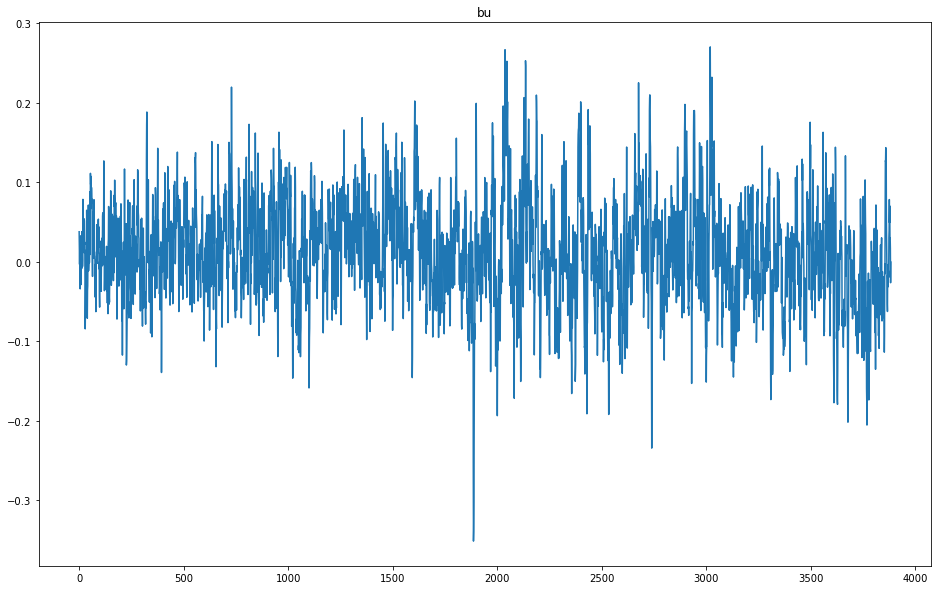

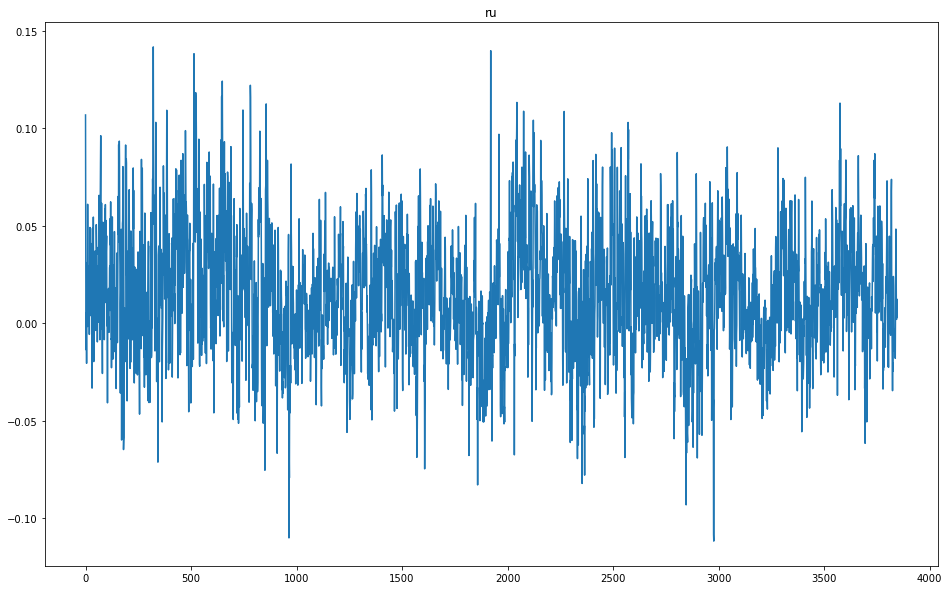

In [56]:
i = 0
for product in product_list[:2]:
    all_signal = get_all_5_signal(np.array(all_5_dates), product, "dbook.1."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [57]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.04, 0.15, 0.002)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


In [58]:
from collections import OrderedDict
def get_signal_5level_pnl(file, product, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61, tranct_ratio=True, 
                   HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern", atr_filter=0, rebate=0):
    ## load data
    data = load(HEAD_PATH+"/pkl level5/"+product+"/"+file)
    S = load(SIGNAL_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    pred = S*reverse
    data = data.reset_index(drop=True)
    pred = pred[data["good"]]
    #atr = load(SIGNAL_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file).reset_index(drop=True)
    #atr = atr[data["good"]].reset_index(drop=True)
    data = data[data["good"]].reset_index(drop=True)
    data["next.bid"] = data["BidPrice1"]
    data["next.bid"][:-1] = data["BidPrice1"][1:]
    data["next.ask"] = data["AskPrice1"]
    data["next.ask"][:-1] = data["AskPrice1"][1:]
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread = data["AskPrice1"]-data["BidPrice1"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        #signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy]+tranct
            change_base[change_sell] = data["next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        ret = -sum(change_base*notional_change_pos)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result


In [59]:
%%time
signal_name = "dbook.1."+str(period)
all_trade_stat = dict([])
SAVE_PATH = "e:/intern"
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_5level_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_5_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

## Wall time: 15min 13s

Wall time: 15min 13s


In [60]:
## save backtest result
save(all_trade_stat, SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pkl")

In [61]:
signal_name = "dbook.1."+str(period)
all_trade_stat = load(SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pkl")
date_str = [n[0:8] for n in all_5_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

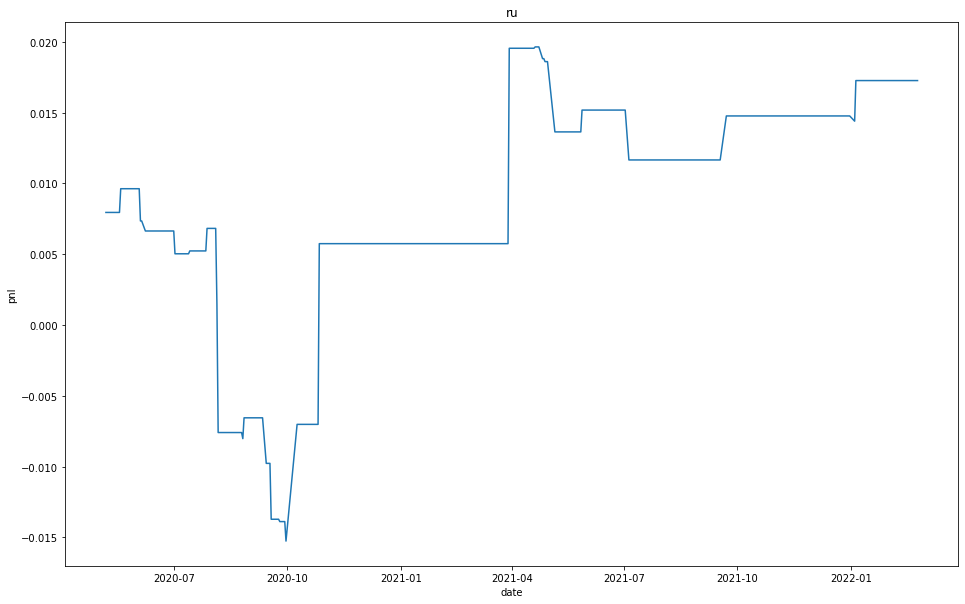

In [62]:
i = 0
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>1*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates, good_pnl.cumsum());

In [77]:
%%time
for i in [2,3,4,5]:
    signal_name = "dbook."+str(i)+"."+str(period)
    all_trade_stat = dict([])
    SAVE_PATH = "e:/intern"
    for product in product_list[:2]:
        spread = product_info[product]["spread"]
        tranct = product_info[product]["tranct"]
        tranct_ratio = product_info[product]["tranct.ratio"]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_5level_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                     reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                      HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                      atr_filter=0.01)
            result = compute([delayed(f_par)(file) for file in all_5_dates])[0]
        trade_stat = get_hft_summary(result, thre_mat, n_days)
        all_trade_stat[product] = trade_stat
    save(all_trade_stat, SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pkl")    

Wall time: 2min 32s


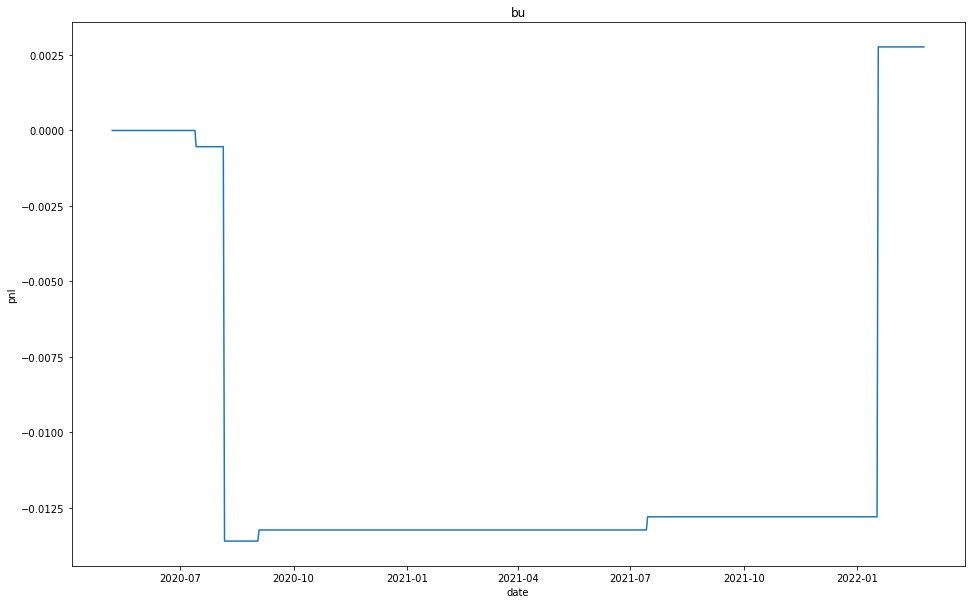

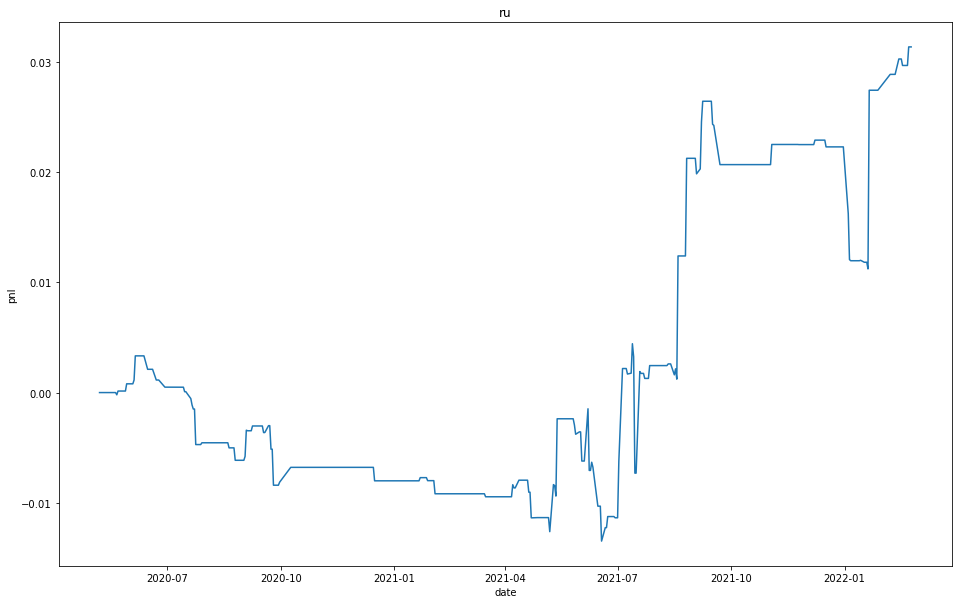

In [64]:
signal_name = "dbook.2."+str(period)
all_trade_stat = load(SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pkl")
i = 0
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates, good_pnl.cumsum());

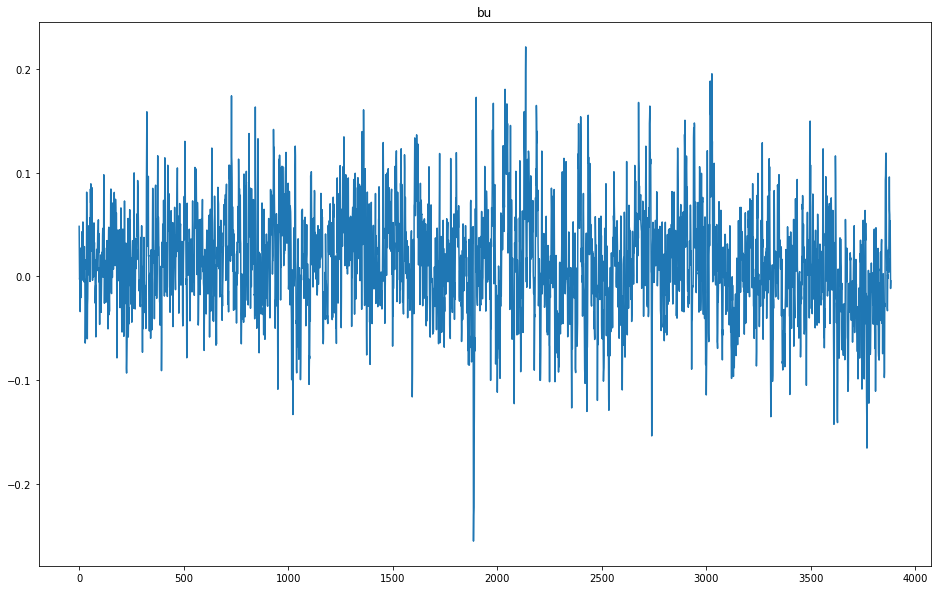

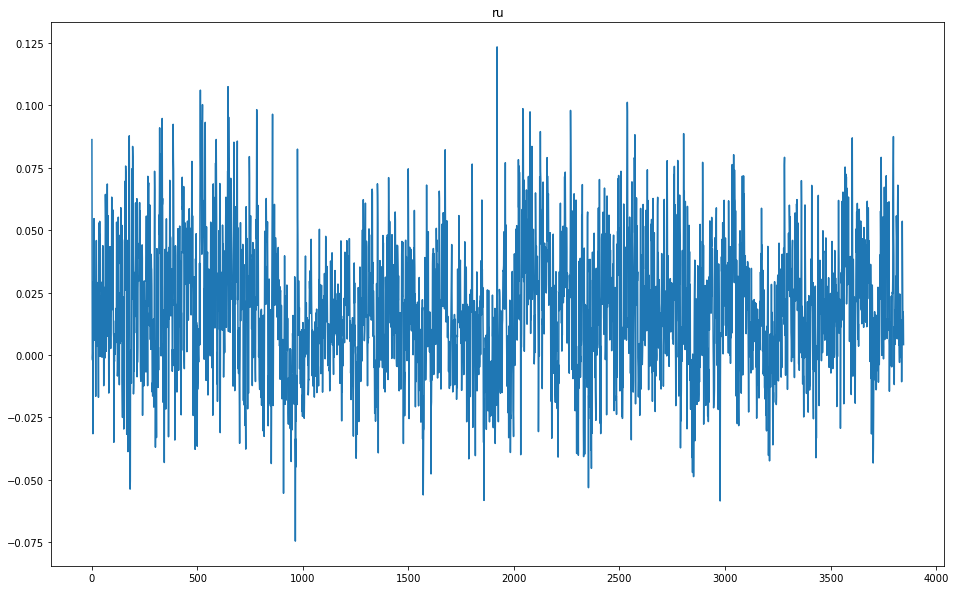

In [65]:
i = 0
for product in product_list[:2]:
    all_signal = get_all_5_signal(np.array(all_5_dates), product, "dbook.all."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [66]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.05, 0.15, 0.005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


In [67]:
%%time
signal_name = "dbook.all."+str(period)
all_trade_stat = dict([])
SAVE_PATH = "e:/intern"
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_5level_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_5_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

## Wall time: 4min 22s


Wall time: 4min 22s


In [68]:
save(all_trade_stat, SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pkl")  

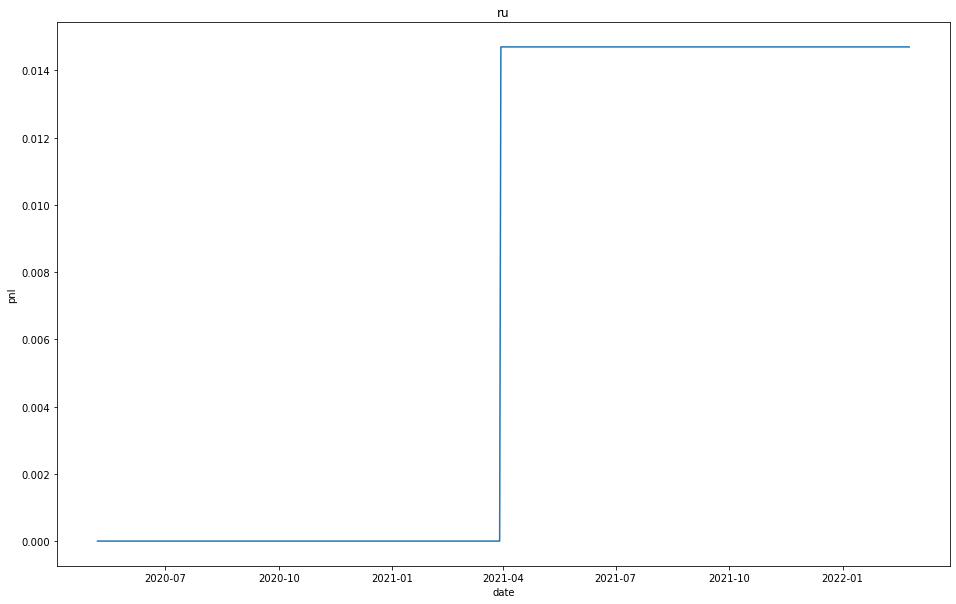

In [69]:
signal_name = "dbook.all."+str(period)
all_trade_stat = load(SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pkl")
i = 0
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates, good_pnl.cumsum());

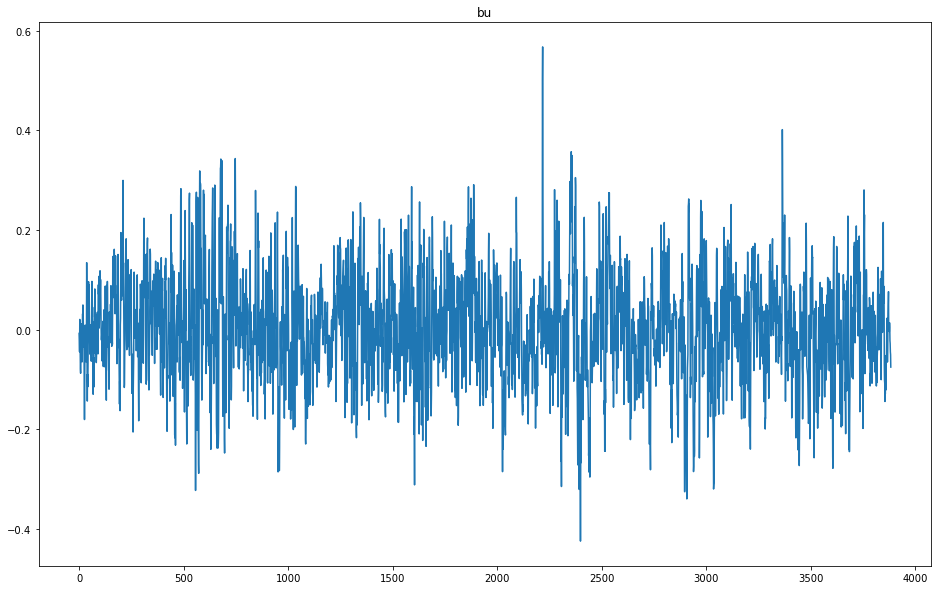

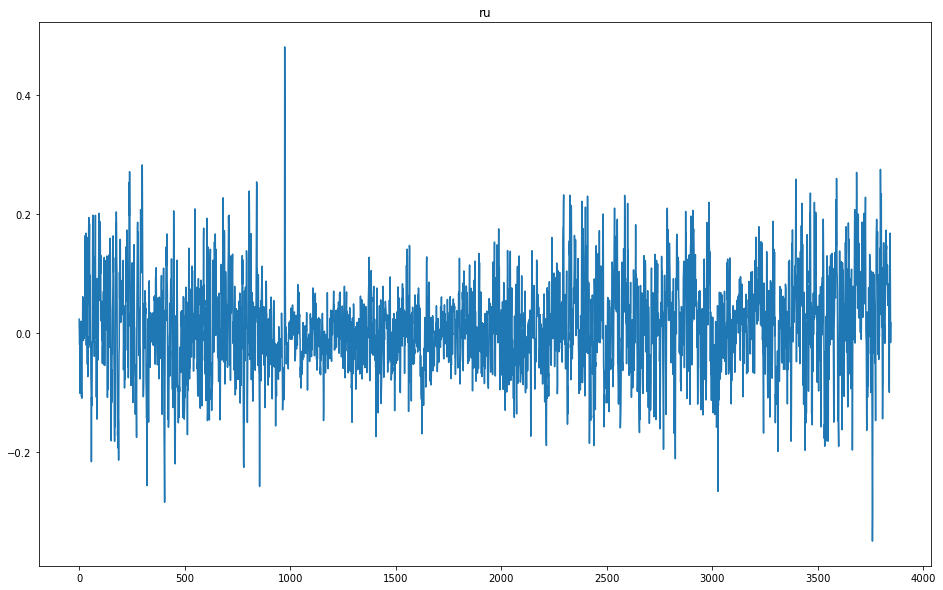

In [70]:
i = 0
for product in product_list[:2]:
    all_signal = get_all_5_signal(np.array(all_5_dates), product, "imb.all."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [71]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.3, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


In [72]:
%%time
signal_name = "imb.all."+str(period)
all_trade_stat = dict([])
SAVE_PATH = "e:/intern"
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_5level_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_5_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

## Wall time: 40min 14s


Wall time: 40min 14s


In [73]:
save(all_trade_stat, SAVE_PATH+"/"+"energy_imb_stat_"+signal_name+".pkl")  

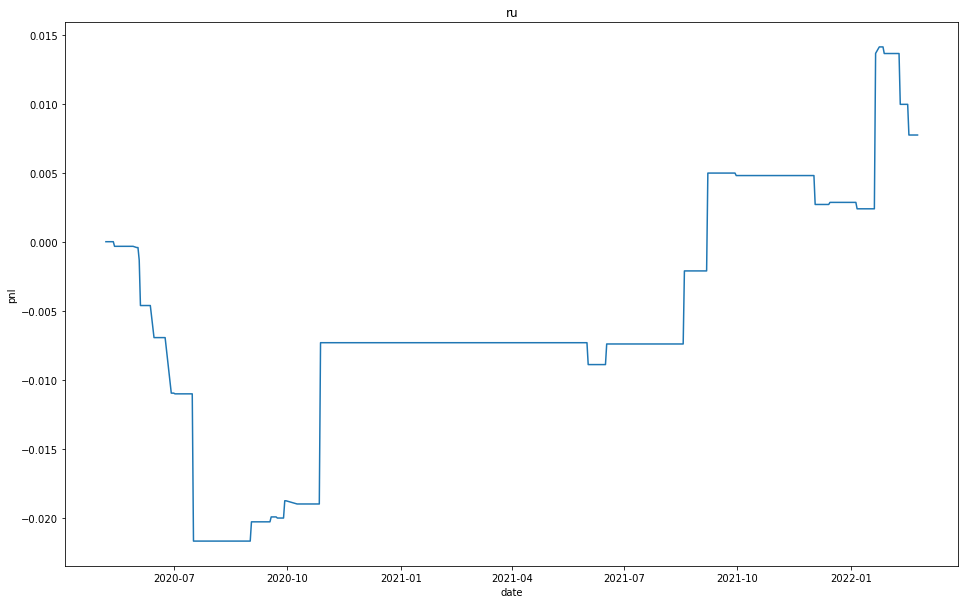

In [74]:
signal_name = "imb.all."+str(period)
all_trade_stat = load(SAVE_PATH+"/"+"energy_imb_stat_"+signal_name+".pkl")
i = 0
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates, good_pnl.cumsum());

- we can see that their results are very similar
- now we go to level 5 data

- Conclusion
- This week we have generated results for all of the 35 signals
- We have compared backtest result with and without atr
- we find that there is not much difference between them
- previously we found that for iorn with atr is better than without atr
- that's because we lower the threhsold for number of trades
- now we use 20 trades for training maybe for i there are not enough trades
- Anyway, currently there are too many signals and hard to tune parameters
- in the future, we can use fewer signals so that we can do the research more efficiently